In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os

base_dir = "/kaggle/input/fer2013"

print("🔍 Inspecting folder structure inside /fer2013...\n")

# List everything in base dir
for item in os.listdir(base_dir):
    item_path = os.path.join(base_dir, item)
    
    if os.path.isdir(item_path):
        print(f"📂 Folder: {item}")
        
        try:
            subitems = os.listdir(item_path)
            print(f"   └── Contains: {len(subitems)} items")
            print(f"   └── Sample: {subitems[:3]}")
            
            # If it's a train or test folder, go deeper
            if item.lower() in ["train", "test"]:
                for subfolder in os.listdir(item_path):
                    subfolder_path = os.path.join(item_path, subfolder)
                    if os.path.isdir(subfolder_path):
                        files = os.listdir(subfolder_path)
                        print(f"      📁 Subfolder '{subfolder}' ➜ {len(files)} files")
                        print(f"      📄 Sample files: {files[:3]}")
        except Exception as e:
            print("   ❌ Error accessing folder contents:", e)
    
    else:
        print(f"📄 File: {item}")


🔍 Inspecting folder structure inside /fer2013...

📂 Folder: test
   └── Contains: 7 items
   └── Sample: ['surprise', 'fear', 'angry']
      📁 Subfolder 'surprise' ➜ 831 files
      📄 Sample files: ['PublicTest_78686873.jpg', 'PrivateTest_58522921.jpg', 'PrivateTest_83796714.jpg']
      📁 Subfolder 'fear' ➜ 1024 files
      📄 Sample files: ['PublicTest_67261410.jpg', 'PrivateTest_80486885.jpg', 'PrivateTest_29930852.jpg']
      📁 Subfolder 'angry' ➜ 958 files
      📄 Sample files: ['PublicTest_3641536.jpg', 'PublicTest_21334851.jpg', 'PrivateTest_56252993.jpg']
      📁 Subfolder 'neutral' ➜ 1233 files
      📄 Sample files: ['PublicTest_85967214.jpg', 'PrivateTest_61407797.jpg', 'PublicTest_24698430.jpg']
      📁 Subfolder 'sad' ➜ 1247 files
      📄 Sample files: ['PublicTest_50867484.jpg', 'PublicTest_4475358.jpg', 'PrivateTest_33171436.jpg']
      📁 Subfolder 'disgust' ➜ 111 files
      📄 Sample files: ['PublicTest_58268614.jpg', 'PublicTest_41393563.jpg', 'PublicTest_85498443.jpg']
 

In [3]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical

# Label map: folder name → numeric class
emotion_label_map = {
    'angry': 0,
    'disgust': 1,
    'fear': 2,
    'happy': 3,
    'sad': 4,
    'surprise': 5,
    'neutral': 6
}

def load_emotion_images_named(directory):
    images, labels = [], []
    for folder_name in os.listdir(directory):
        folder_path = os.path.join(directory, folder_name)
        if not os.path.isdir(folder_path):
            continue
        label = emotion_label_map.get(folder_name.lower())
        if label is None:
            print(f"⚠️ Skipping unknown folder: {folder_name}")
            continue
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            try:
                img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue
                img = cv2.resize(img, (48, 48))
                images.append(img / 255.0)
                labels.append(label)
            except Exception as e:
                print(f"❌ Error with {file_path}: {e}")
    images = np.expand_dims(np.array(images), -1)
    labels = to_categorical(np.array(labels), num_classes=7)
    return images, labels


In [4]:
train_dir = "/kaggle/input/fer2013/train"
test_dir = "/kaggle/input/fer2013/test"

X_train_emotion, y_train_emotion = load_emotion_images_named(train_dir)
X_test_emotion, y_test_emotion = load_emotion_images_named(test_dir)

print("✅ Final Shapes:")
print("Train:", X_train_emotion.shape, y_train_emotion.shape)
print("Test: ", X_test_emotion.shape, y_test_emotion.shape)


✅ Final Shapes:
Train: (28709, 48, 48, 1) (28709, 7)
Test:  (7178, 48, 48, 1) (7178, 7)


In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization

# Build the model
emotion_model = Sequential([
    Conv2D(64, (3,3), activation='relu', input_shape=(48,48,1)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),
    
    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),
    
    Conv2D(256, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')  # 7 emotion classes
])

# Compile
emotion_model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

# Summary
emotion_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-06-26 10:53:49.625114: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 46, 46, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 46, 46, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 21, 21, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 21, 21, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 896,775 (3.42 MB)

 Trainable params: 895,879 (3.42 MB)

 Non-trainable params: 896 (3.50 KB)

In [6]:
# Train
history_emotion = emotion_model.fit(
    X_train_emotion, y_train_emotion,
    validation_data=(X_test_emotion, y_test_emotion),
    epochs=30,
    batch_size=64,
    verbose=1
)


Epoch 1/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 250s 545ms/step - accuracy: 0.2290 - loss: 2.0707 - val_accuracy: 0.3022 - val_loss: 1.7380
Epoch 2/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 283s 630ms/step - accuracy: 0.3078 - loss: 1.6760 - val_accuracy: 0.3252 - val_loss: 1.6718
Epoch 3/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 240s 535ms/step - accuracy: 0.3596 - loss: 1.5940 - val_accuracy: 0.2675 - val_loss: 1.7468
Epoch 4/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 239s 533ms/step - accuracy: 0.3836 - loss: 1.5496 - val_accuracy: 0.4583 - val_loss: 1.4153
Epoch 5/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 238s 531ms/step - accuracy: 0.4196 - loss: 1.4795 - val_accuracy: 0.4663 - val_loss: 1.4212
Epoch 6/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 238s 529ms/step - accuracy: 0.4436 - loss: 1.4278 - val_accuracy: 0.4482 - val_loss: 1.4618
Epoch 7/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 228s 508ms/step - accuracy: 0.4608 - loss: 1.3810 - val_accuracy: 0.4446 - val_loss: 1.4405
Epoch 8/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 238s 531ms/step - accuracy: 0.4700 -

/tmp/ipykernel_35/243170552.py:25: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/243170552.py:25: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


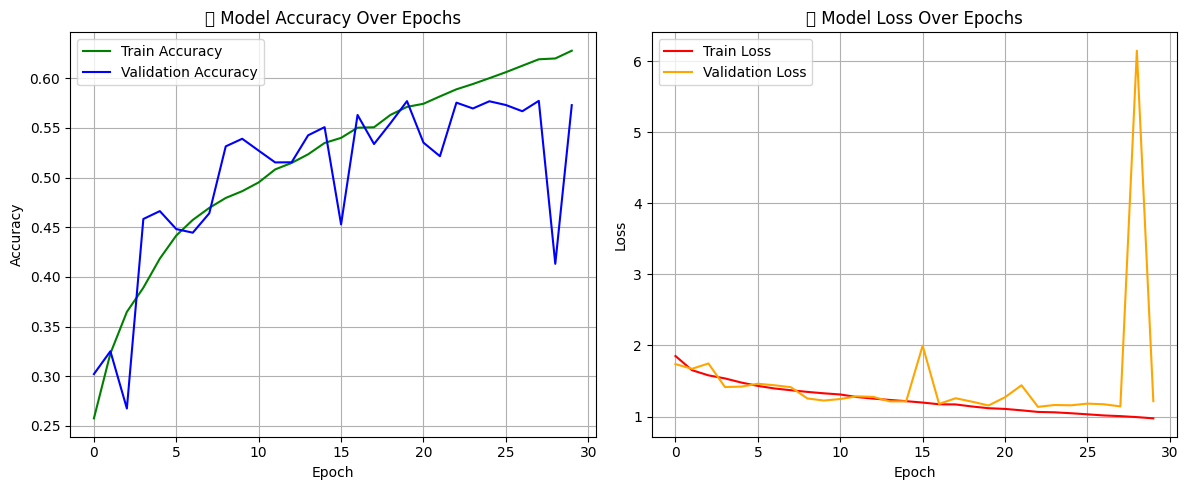

In [7]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_emotion.history['accuracy'], label='Train Accuracy', color='green')
plt.plot(history_emotion.history['val_accuracy'], label='Validation Accuracy', color='blue')
plt.title('📈 Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_emotion.history['loss'], label='Train Loss', color='red')
plt.plot(history_emotion.history['val_loss'], label='Validation Loss', color='orange')
plt.title('📉 Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [8]:
emotion_model.save("emotion_detector_model.h5")
print("🎉 Emotion model saved successfully!")


🎉 Emotion model saved successfully!
